# Walmart Sales

We use the data from the Walmart Sales Forecasting competition. We want to predict sales for 3 the following week.

In [6]:
import pandas as pd

from darts import TimeSeries
from utils import TimeseriesExperiment, Dataset


DATASET_NAME = "walmart-sales"

## Load the data

In [7]:
STORE_ID = 1

# Load data
df_train = pd.read_csv("data/walmart-sales/train.csv")
df_features = pd.read_csv("data/walmart-sales/features.csv")

# Get data from one store
df = df_train[df_train["Store"] == STORE_ID]
df = df[df["Dept"] == STORE_ID]

# Drop redundant columns
df = df.drop(["Store", "Dept", "IsHoliday"], axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date").resample("W").mean()


df_features = df_features.drop(
    ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"], axis=1
)
df_features = df_features[df_features["Store"] == STORE_ID]
df_features["Date"] = pd.to_datetime(df_features["Date"])
df_features = df_features.set_index("Date").resample("W").mean()

df = df.join(df_features, how="left")

df.head()

,Weekly_Sales,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
Date,,,,,,,
2010-02-07,24924.50,1.0,42.31,2.572,211.096358,8.106,0.0
2010-02-14,46039.49,1.0,38.51,2.548,211.242170,8.106,1.0
2010-02-21,41595.55,1.0,39.93,2.514,211.289143,8.106,0.0
2010-02-28,19403.54,1.0,46.63,2.561,211.319643,8.106,0.0
2010-03-07,21827.90,1.0,46.50,2.625,211.350143,8.106,0.0


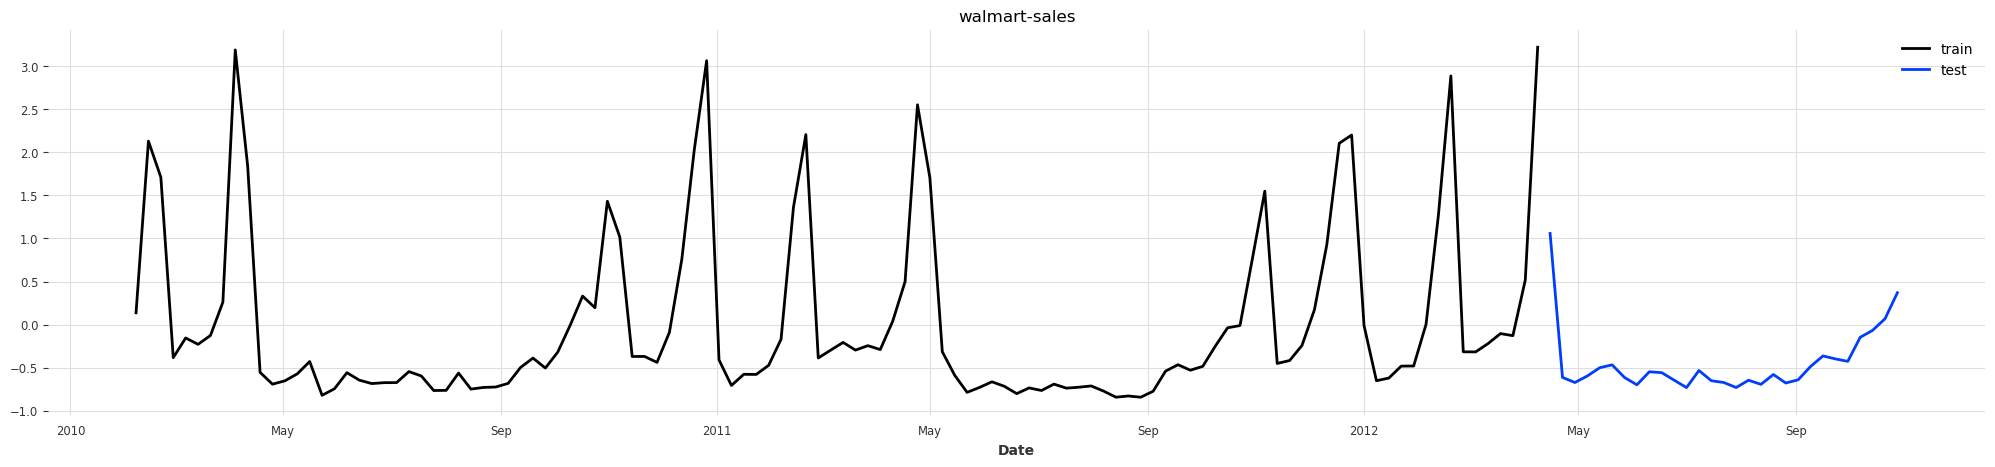

2012-04-08 00:00:00
2012-04-15 00:00:00


In [8]:
# create df_target but keep it as a TimeSeries
df_target = df["Weekly_Sales"]
df_features = df.drop("Weekly_Sales", axis=1)

target = TimeSeries.from_series(df_target, freq="W", fill_missing_dates=True)
covariates = TimeSeries.from_dataframe(df_features, freq="W", fill_missing_dates=True)

dataset = Dataset(target, "walmart-sales", past_covariates=covariates)
dataset.plot_train_test()

print(dataset.train.time_index[-1])
print(dataset.test.time_index[0])

## Models

### Baseline

In [9]:
from darts.models import NaiveSeasonal

model = NaiveSeasonal(K=1)

experiment1 = TimeseriesExperiment(model, dataset, retrain=True)

experiment1.run()

TypeError: NaiveSeasonal.fit() got an unexpected keyword argument 'past_covariates'

In [ ]:
# arima
from darts.models import ARIMA

model = ARIMA()

experiment2 = TimeseriesExperiment(
    model, dataset, {"p": [1, 3, 5], "d": [1], "q": [0]}, retrain=True
)

experiment2.run()

Searching for best parameters {'p': [1, 3, 5], 'd': [1], 'q': [0]}


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

ValueError: Model cannot be fit/trained with `past_covariates`.


ValueError: Model cannot be fit/trained with `past_covariates`.

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


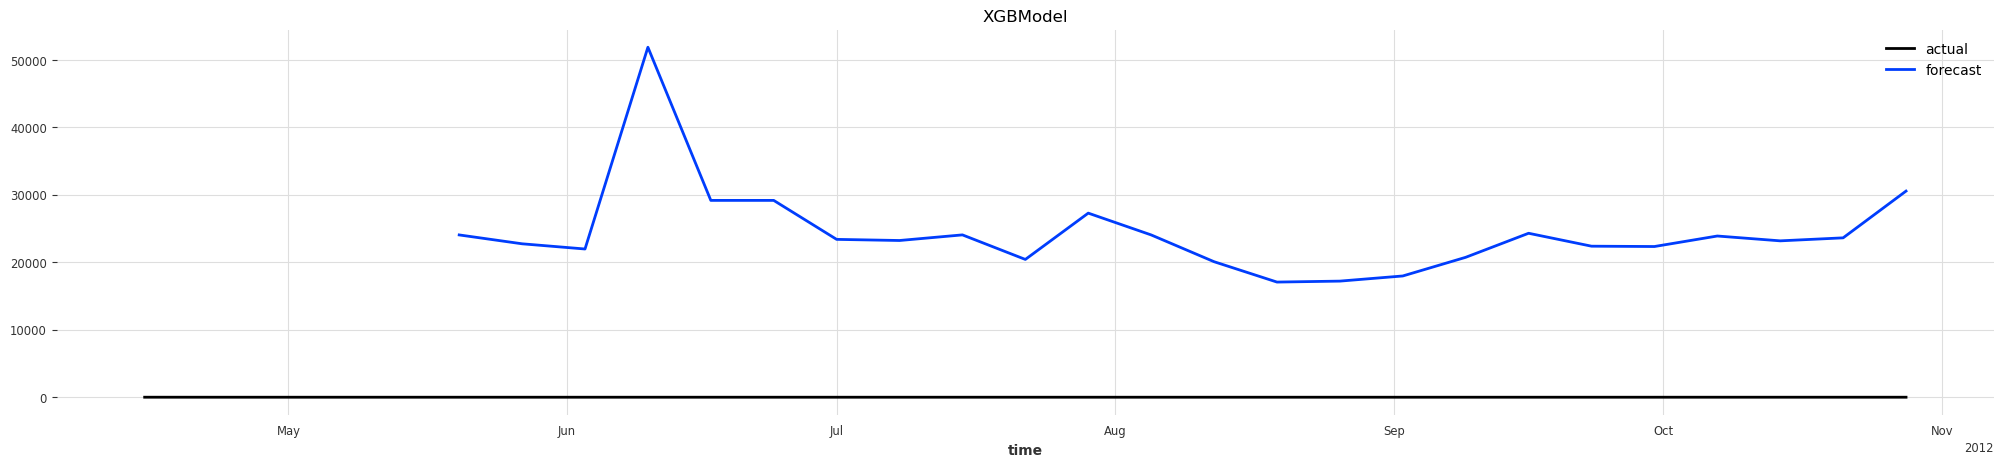

{'mape': 79697588833.77583,
 'mse': 7.175035811938487e+16,
 'rmse': 267862573.19637784,
 'mae': 258395244.48008624,
 'model': 'XGBModel',
 'forecast_horizon': 3,
 'dataset': 'walmart-sales',
 'experiment_time': 1716396502.834071,
 'parameters': OrderedDict([('lags', 3),
              ('lags_past_covariates', 1),
              ('lags_future_covariates', None),
              ('output_chunk_length', 1),
              ('output_chunk_shift', 0),
              ('add_encoders', None),
              ('likelihood', None),
              ('quantiles', None),
              ('random_state', None),
              ('multi_models', True),
              ('use_static_covariates', True),
              ('max_depth', 7),
              ('n_estimators', 10)])}

In [11]:
from darts.models import XGBModel

model = XGBModel(lags=1)

experiment3 = TimeseriesExperiment(
    model,
    dataset,
    {
        "lags": [3, 7, 14],
        "lags_past_covariates": [1, 2],
        "max_depth": [3, 5, 7],
        "n_estimators": [10, 25, 50, 100],
        "output_chunk_length": [1, 3],
    },
    use_pretrained_model=True,
)

experiment3.run()

In [12]:
from darts.models import Prophet

model_prophet = Prophet()

experiment_prophet = TimeseriesExperiment(model_prophet, dataset, retrain=True)

experiment_prophet.run()

TypeError: FutureCovariatesLocalForecastingModel.fit() got an unexpected keyword argument 'past_covariates'

In [13]:
from darts.models.forecasting.rnn_model import RNNModel

lstm_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0.1,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM",
    input_chunk_length=1,
    random_state=42,
    pl_trainer_kwargs={"accelerator": "cpu"},
)

experiment_lstm = TimeseriesExperiment(lstm_model, dataset, retrain=True)

experiment_lstm.run()

ValueError: The model does not support `past_covariates`. It only supports `future_covariates`.


ValueError: The model does not support `past_covariates`. It only supports `future_covariates`.

## Results

In [14]:
from utils import read_results

df = read_results()
df = df[df["dataset"] == "walmart-sales"]

df

,mape,mse,rmse,mae,model,forecast_horizon,dataset,experiment_time,parameters
1,100.006604,346017156.072349,18601.53639,18377.197857,Prophet,3,walmart-sales,1716310144.610927,"{'add_seasonalities': None, 'country_holidays'..."
3,100.001327,667609409.444593,25838.138661,25788.380443,RNNModel,3,walmart-sales,1716310158.679889,"{'model': 'LSTM', 'hidden_dim': 20, 'n_rnn_lay..."
16,100.00323,345995538.976603,18600.955324,18376.598398,NaiveSeasonal,3,walmart-sales,1716311448.290205,{'K': 1}
20,79697588833.775833,71750358119384872.0,267862573.196378,258395244.480086,XGBModel,3,walmart-sales,1716396502.834071,"{'lags': 3, 'lags_past_covariates': 1, 'lags_f..."
24,910.973558,2.090447,1.445838,0.928657,ARIMA,3,walmart-sales,1715278529.295173,"{'p': 1, 'd': 1, 'q': 0, 'seasonal_order': [0,..."


<Axes: xlabel='model', ylabel='mse'>

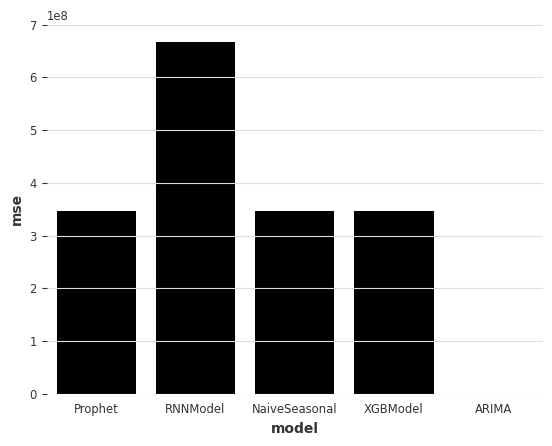

In [ ]:
import seaborn as sns

sns.barplot(data=df, x="model", y="mse")